In [59]:

import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append('../')


from src_experiment import get_data, train_model, get_model
from src_experiment import get_storage_path
from src_experiment.estimate_quantities import EstimateQuantities1Run, AverageEstimates


In [60]:
train = get_data('breast_cancer', 'training', batch_size=50)
test = get_data('breast_cancer', 'testing', batch_size=50)

In [61]:
def plot_training(res):
    ax = res[["train_loss", "test_loss"]].plot(
        figsize=(10, 10),
        color=["blue", "blue"],
        style=["-", "--"],
        ylabel="Loss",
    )

    ax2 = res[["train_accuracy", "test_accuracy"]].plot(
        ax=ax,
        secondary_y=True,
        color=["red", "red"],
        style=["-", "--"],
    )

    ax.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")

    # Fix legends (pandas splits them)
    lines1, labels1 = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(lines1 + lines2, labels1 + labels2, loc="center right")

    plt.show()
    
def plot_results_on_ax(res, ax, title=None):
    res[["train_loss", "test_loss"]].plot(
        ax=ax, style=["-", "--"], legend=False
    )

    ax_acc = ax.twinx()
    res[["train_accuracy", "test_accuracy"]].plot(
        ax=ax_acc, style=["-", "--"], legend=False
    )

    ax.set(xlabel="Epochs", ylabel="Loss", title=title)
    ax_acc.set_ylabel("Accuracy")

    return ax, ax_acc


def plot_all_results(results, titles=None, run_number=0):
    fig, axes = plt.subplots(2, 3, figsize=(14, 7))
    axes = axes.ravel()

    acc_axes = []

    for i, res in enumerate(results):
        _, ax_acc = plot_results_on_ax(
            res,
            axes[i],
            None if titles is None else titles[i],
        )
        acc_axes.append(ax_acc)

    # Legend from first subplot (both y-axes)
    lines = axes[0].lines + acc_axes[0].lines
    labels = ["Train loss", "Test loss", "Train acc", "Test acc"]

    fig.legend(lines, labels, loc="upper left", ncol=4)

    plt.tight_layout(rect=[0, 0, 1, 0.93])
    fig.suptitle(f"Run number: {run_number}")
    plt.show()

## Test training

In [62]:
# # model1 = get_model(type="small_wbc", seed=0)
# # model2 = get_model(type="decreasing_wbc", seed=0)
# # results1 = train_model(model1, train, test, epochs=500)
# # results2 = train_model(model2, train, test, epochs=500)


# for model_name in ["small_wbc", "decreasing_wbc"]:
#     for seed in [0]: 
#         model = get_model(type=model_name, seed=seed)
#         print(f"Training model {model_name} with seed {seed}")
#         results, = train_model(model, train, test, epochs=500)
#         plot_training(results)

In [63]:
# plot_training(results1[0])
# plot_training(results2[0])

## Print out all stored training data

In [64]:
# Load already trained models and plot their results

def plot_stored_results(model_name, run_number=0):
    datapath = get_storage_path("wbc", model_name=model_name, run_number=run_number)

    frame = pd.read_csv(os.path.join(datapath, "run_summary.csv"))
    plot_training(frame)

In [65]:
# for model_name in ["small", "decreasing"]:
#     for run_number in np.arange(15):
#         print(f"Plotting stored results for model {model_name}, run {run_number}")
#         plot_stored_results(model_name, run_number=run_number)


## Load and test number counts

In [66]:
# Try to load counts


def load_counts(model_name, run_number=0):
    datapath = get_storage_path("wbc", model_name=model_name, run_number=run_number)
    counts_path = os.path.join(datapath, "number_counts_per_epoch.pkl")
    return pd.read_pickle(counts_path)

In [67]:
testframe = load_counts("small", run_number=0)

## Estimate quantites

In [68]:
# Investigate the counts and MI estimates
run_test = EstimateQuantities1Run(
    data_dir=get_storage_path("wbc", model_name="small", run_number=4)
)


In [69]:
# run_test["MI_KL"]

In [70]:
import matplotlib.pyplot as plt

def plot_both_KL_IS(estimates, lw=2):
    """
    Plot all layers except the last one on the same figure as functions of epoch.
    
    Parameters
    ----------
    df : pd.DataFrame
        DataFrame with columns 'epoch' and layers like 'l1', 'l2', ...
    lw : float
        Line width for the curves.
    """
    # All columns except 'epoch' and the last layer
    MI = estimates["MI_KL"]
    IS = estimates["MI_IS"]
    
    # layers = df.columns[1:-1]  # skip first (epoch) and last

    fig, (ax0, ax1) = plt.subplots(nrows=2, ncols=1, figsize=(10, 7), sharex=True)

    for Q, ax, labels in zip([MI, IS], [ax0, ax1], ["KL", "IS"]):
        for layer in Q.columns[1:-1]:
            ax.plot(Q["epoch"], Q[layer], lw=lw, label=layer)
    
    ax0.grid(True)
    ax1.grid(True)
    ax1.set_xlabel("Epoch")
    ax0.set_ylabel("Kullback-Leibler MI")
    ax1.set_ylabel("Itakura-Saito MI")
    fig.suptitle("Breast Cancer dataset - one run")
    plt.legend()
    plt.tight_layout()
    plt.show()

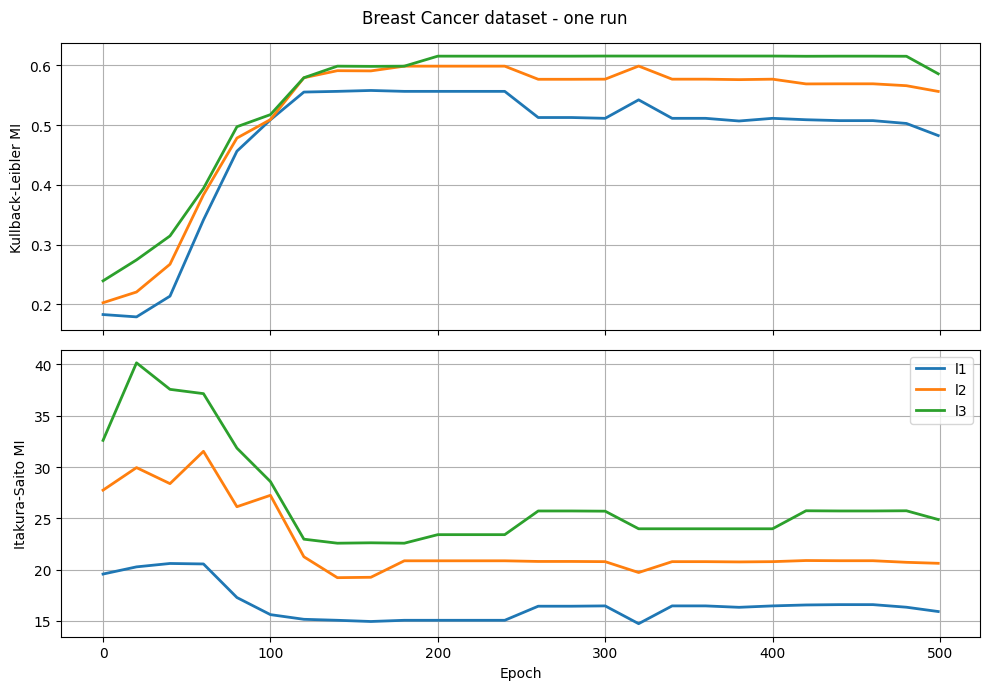

In [71]:
plot_both_KL_IS(run_test.get_estimates(), lw=2)

In [72]:
# for run_number in np.arange(15):
#     run = EstimateQuantities1Run(
#         data_dir=get_storage_path("wbc", model_name="small", run_number=run_number)
#     )
#     plot_both_KL_IS(run, lw=1)

## Attempt to find averages

In [73]:
avg = AverageEstimates([get_storage_path("wbc", model_name="small", run_number=int(rn)) for rn in np.arange(15)])
agg = avg._collect()

In [74]:
# Aggregated scores
len(agg["MI_IS"])

15

In [75]:
# Concatenate
agg_concat = pd.concat(agg["MI_KL"], keys=np.arange(len(agg["MI_KL"])), names=["run", "row"]).reset_index(level="run")

In [76]:
agg_concat

,run,epoch,l1,l2,l3,l4
row,,,,,,
0,0,0,0.043748,0.071128,0.072659,0.072659
1,0,20,0.042177,0.072223,0.073631,0.073631
2,0,40,0.040268,0.085419,0.089659,0.089659
3,0,60,0.050273,0.071439,0.094160,0.094160
4,0,80,0.090454,0.119324,0.160292,0.160292
...,...,...,...,...,...,...
21,14,420,0.544593,0.603884,0.616044,0.616044
22,14,440,0.549693,0.603689,0.615850,0.615850
23,14,460,0.545867,0.603689,0.615850,0.615850


In [77]:
summary = (agg_concat.groupby("epoch")[[col for col in agg_concat.columns[1:-1] if col not in ["run", "epoch"]]].agg(["mean", "std"]))

In [ ]:
means = summary.xs('mean', axis=1, level=1,).reset_index()
stds = summary.xs('std', axis=1, level=1)

In [79]:
means

,l1,l2,l3
epoch,,,
0,0.264150,0.298405,0.309036
20,0.324998,0.358646,0.378028
40,0.374595,0.412036,0.426094
60,0.399825,0.437767,0.452152
80,0.427889,0.465012,0.477160
100,0.449550,0.484405,0.497648
120,0.458990,0.497912,0.509777
140,0.474492,0.519146,0.528623
160,0.505369,0.543761,0.556157


In [ ]:
print(run_test.get_estimates())

{'MI_KL':     epoch        l1        l2        l3        l4
0       0  0.182982  0.202748  0.239387  0.239387
1      20  0.179073  0.220699  0.274394  0.274394
2      40  0.213772  0.267143  0.314503  0.314503
3      60  0.341332  0.383353  0.394062  0.394062
4      80  0.456320  0.478268  0.497235  0.497235
5     100  0.508776  0.509131  0.517449  0.521431
6     120  0.555216  0.579177  0.579177  0.579177
7     140  0.556377  0.590968  0.598539  0.615289
8     160  0.557877  0.590614  0.598185  0.614935
9     180  0.556377  0.598539  0.598539  0.615289
10    200  0.556377  0.598539  0.615289  0.615289
11    220  0.556377  0.598539  0.615289  0.615289
12    240  0.556377  0.598539  0.615289  0.615289
13    260  0.512616  0.576592  0.615289  0.615289
14    280  0.512616  0.576592  0.615289  0.615289
15    300  0.511268  0.576774  0.615472  0.615472
16    320  0.542193  0.598722  0.615472  0.615472
17    340  0.511268  0.576774  0.615472  0.615472
18    360  0.511268  0.576774  0.615472 

In [ ]:
avg.means["MI_KL"]

epoch
0      0.264150
20     0.324998
40     0.374595
60     0.399825
80     0.427889
100    0.449550
120    0.458990
140    0.474492
160    0.505369
180    0.505828
200    0.512153
220    0.515121
240    0.511082
260    0.508753
280    0.508753
300    0.508362
320    0.509762
340    0.507985
360    0.511574
380    0.511688
400    0.510073
420    0.506677
440    0.505754
460    0.507674
480    0.513285
499    0.513363
Name: l1, dtype: float64

KeyError: 'epoch'

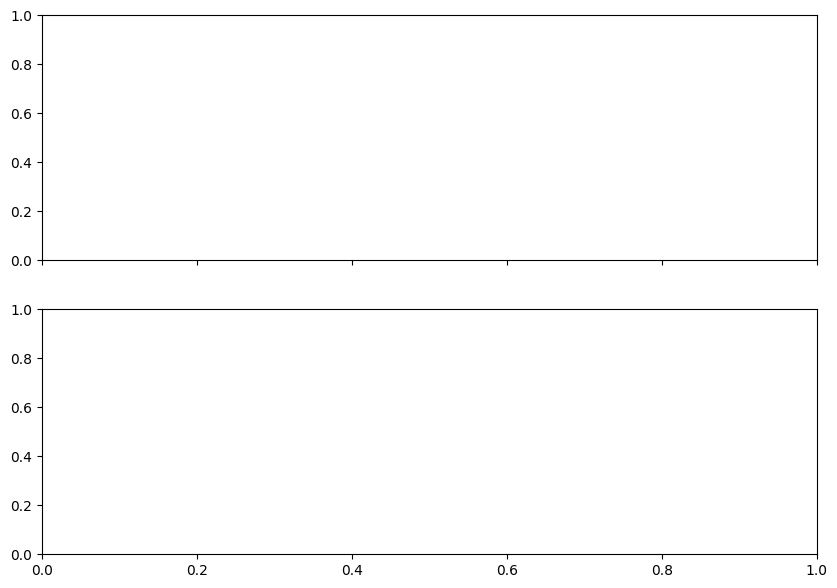

In [87]:
plot_both_KL_IS(avg.means, lw=2)